In [1]:
!pip install pydicom opencv-python-headless albumentations torch torchvision timm torch-tensorrt -f https://github.com/NVIDIA/Torch-TensorRT/releases


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://github.com/NVIDIA/Torch-TensorRT/releases
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [13 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/ds/4z7lc9ld4mqb377_3t2v4lxm0000gn/T/pip-install-8orqb8h5/torch-tensorrt_3d983ad8e57d48bc8ef6f6c0a250c5e6/setup.py", line 125, in <module>
          raise RuntimeError(open("ERROR.txt", "r").read())
      RuntimeError:
      ###########################################################################################
      The package you are trying to install is only a placeholder project on PyPI.org repository.
      To install Torch-TensorRT please run the following command:
      
      $ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


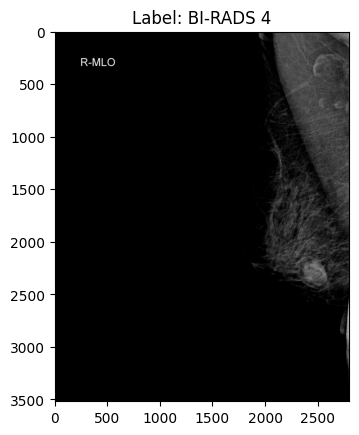

In [4]:
import os
import pydicom
import numpy as np
import cv2
import pandas as pd
import torch
from albumentations import Compose, Normalize
from pydicom.pixel_data_handlers.util import apply_voi_lut
from torch.utils.data import DataLoader, Dataset
import timm
from torchvision import transforms
import utils

# Ruta al dataset y al archivo CSV de anotaciones
dataset_path = '/Volumes/m2/Memoria/Datasets/Vincomprimido'
annotations_csv_path = '/Volumes/m2/Memoria/Datasets/Vincomprimido/metacomprimida.csv'

# Clase para cargar y preprocesar las imágenes DICOM
class MammoDataset(Dataset):
    def __init__(self, annotations_csv, dataset_path, transform=None):
        self.annotations = pd.read_csv(annotations_csv)
        self.dataset_path = dataset_path
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Obtener el series_id y image_id del archivo CSV
        series_id = self.annotations.iloc[idx]['study_id_x']
        image_id = self.annotations.iloc[idx]['image_id']
        
        # Construir la ruta al archivo DICOM
        dicom_path = os.path.join(self.dataset_path, series_id, f'{image_id}.dicom')
        
        # Cargar el archivo DICOM
        dicom = pydicom.dcmread(dicom_path)
        
        # Aplicar VOILUT si es necesario
        if 'VOILUTFunction' in dicom:
            image = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            image = dicom.pixel_array
        
        # Normalizar la imagen
        image = image.astype(np.float32)
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = (image * 255).astype(np.uint8)
        
        # Convertir a 3 canales (RGB)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        # Aplicar transformaciones si las hay
        if self.transform:
            image = self.transform(image=image)['image']
        
        # Obtener la etiqueta (si es necesario)
        label = self.annotations.iloc[idx]['breast_birads_x']
        
        return image, label

# Configuración de transformaciones
transform = Compose([
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, always_apply=True)
])

# Crear el dataset
dataset = MammoDataset(annotations_csv_path, dataset_path, transform=transform)

# Cargar una muestra para visualizar
image, label = dataset[23]

# Mostrar la imagen usando OpenCV
#cv2.imshow('Mammogram', image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(f'Label: {label}')
plt.show()
